# Part  : Model choice 

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings
warnings.simplefilter('ignore')

# Load the dataset
csv_path = '/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv'
data = pd.read_csv(csv_path, low_memory=False)

In [2]:
# Drop unwanted columns
columns_to_omit = [
    "frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4",
    "arp.dst.proto_ipv4", "http.file_data", "http.request.full_uri",
    "icmp.transmit_timestamp", "http.request.uri.query", "tcp.options",
    "tcp.payload", "tcp.srcport", "tcp.dstport", "udp.port", "mqtt.msg"
]
data.drop(columns=columns_to_omit, inplace=True)

# Clean dataset
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data = shuffle(data)

print(data['Attack_type'].value_counts())


Attack_type
Normal                   1363998
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  48544
Uploading                  36807
Backdoor                   24026
Port_Scanning              19977
XSS                        15066
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: count, dtype: int64


In [3]:
# === Encoding Categorical Features ===

def one_hot_encode_column(dataset, col_name):
    encoded = pd.get_dummies(dataset[col_name], prefix=col_name)
    dataset.drop(columns=[col_name], inplace=True)
    return pd.concat([dataset, encoded], axis=1)

categorical_features = [
    'http.request.method', 'http.referer', 'http.request.version',
    'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.protoname', 'mqtt.topic'
]

for feature in categorical_features:
    data = one_hot_encode_column(data, feature)

# Save processed dataset
data.to_csv('preprocessed_DNN.csv', index=False)


In [4]:

# === Load and Inspect Processed Data ===

df = pd.read_csv('./preprocessed_DNN.csv')
print(df['Attack_type'].value_counts())
df.info()



Attack_type
Normal                   1363998
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  48544
Uploading                  36807
Backdoor                   24026
Port_Scanning              19977
XSS                        15066
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909671 entries, 0 to 1909670
Data columns (total 97 columns):
 #   Column                                                                                                Dtype  
---  ------                                                                                                -----  
 0   arp.opcode                                                                                            float64
 1   arp.

In [5]:
# === Feature Engineering ===

target_column = 'Attack_type'
features = [col for col in df.columns if col != target_column]



In [6]:
# Check empty columns
null_only_cols = df.columns[df.isnull().all()].tolist()
print("Empty columns:", null_only_cols)


Empty columns: []


In [7]:

# Sample inspection
exclusion_fields = ["icmp.unused", "http.tls_port", "dns.qry.type", "mqtt.msg_decoded_as"]
print(df[exclusion_fields[-1]].value_counts())


mqtt.msg_decoded_as
0.0    1909671
Name: count, dtype: int64


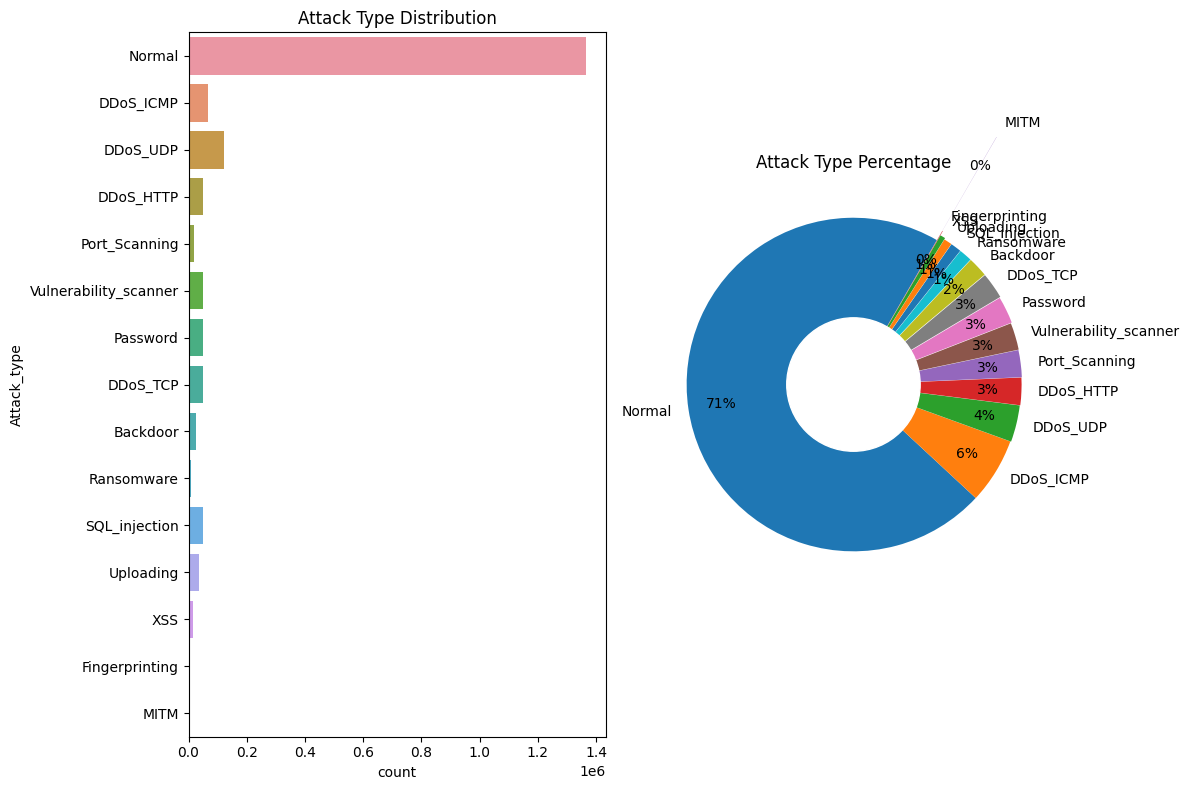

In [8]:

# === Visualization ===

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

labels = df[target_column].unique()
sizes = df[target_column].value_counts()
explode_vals = (np.array(sizes) / sizes.sum())[::-1]

axes[1].pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=0.8, explode=explode_vals, startangle=60)
axes[1].add_artist(plt.Circle((0, 0), 0.4, color='white'))

sns.countplot(data=df, y=target_column, ax=axes[0])
axes[0].set_title("Attack Type Distribution")
axes[1].set_title("Attack Type Percentage")
plt.tight_layout()
plt.show()



In [9]:
# === Train/Test Preparation ===

X_all = df.drop(columns=[target_column])
y_all = df[target_column]



In [10]:
# Balancing dataset
required_per_class = 10000
balanced_features = []

for label in y_all.unique():
    label_subset = X_all[y_all == label]
    if len(label_subset) >= required_per_class:
        sampled = label_subset.sample(n=required_per_class, random_state=42)
    else:
        sampled = label_subset.sample(n=required_per_class, replace=True, random_state=42)
    balanced_features.append(sampled)

X_bal = pd.concat(balanced_features)
y_bal = pd.Series(np.repeat(y_all.unique(), required_per_class))

print("Balanced classes:\n", y_bal.value_counts())



Balanced classes:
 Normal                   10000
DDoS_ICMP                10000
DDoS_UDP                 10000
DDoS_HTTP                10000
Port_Scanning            10000
Vulnerability_scanner    10000
Password                 10000
DDoS_TCP                 10000
Backdoor                 10000
Ransomware               10000
SQL_injection            10000
Uploading                10000
XSS                      10000
Fingerprinting           10000
MITM                     10000
Name: count, dtype: int64


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=1, stratify=y_all)

# === Encoding Labels ===

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

print("Label Classes:", encoder.classes_)

Label Classes: ['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_TCP' 'DDoS_UDP' 'Fingerprinting'
 'MITM' 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'Vulnerability_scanner' 'XSS']


In [12]:
# === Normalize Features ===

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for model input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
input_shape = X_train.shape[1:]

Train shape: (1527736, 96, 1), Test shape: (381935, 96, 1)


In [13]:
# # Display data info
# df.info()

In [14]:
# # Separate features and labels
# label_col = "Attack_label"
# feat_cols = [col for col in df.columns if col != label_col]

# # Identify empty columns
# empty_cols = [col for col in df.columns if df[col].isnull().all()]
# print("Empty columns:", empty_cols)

# # Skip list
# skip_list = ["icmp.unused", "http.tls_port", "dns.qry.type", "mqtt.msg_decoded_as"]
# print(df[skip_list[3]].value_counts())

# # Plot attack type distribution
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
# explode = list((np.array(list(df[label_col].dropna().value_counts())) / sum(list(df[label_col].dropna().value_counts())))[::-1])[:]
# labels = list(df[label_col].dropna().unique())[:]
# sizes = df[label_col].value_counts()[:]

# ax2.pie(sizes, explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.8)
# ax2.add_artist(plt.Circle((0, 0), 0.4, fc='white'))
# sns.countplot(y=label_col, data=df, ax=ax1)
# ax1.set_title("Count of each Attack label")
# ax2.set_title("Percentage of each Attack label")
# plt.show()
# X = df.drop(label_col, axis=1)
# y = df[label_col]

# min_samples_per_class = 10000
# balanced_dfs = []

# for class_name in y.unique():
#     class_data = X[y == class_name]
#     if len(class_data) >= min_samples_per_class:
#         balanced_class = class_data.sample(n=min_samples_per_class, random_state=42)
#     else:
#         balanced_class = class_data.sample(n=min_samples_per_class, replace=True, random_state=42)
#     balanced_dfs.append(balanced_class)

# X_balanced = pd.concat(balanced_dfs)
# y_balanced = pd.Series([class_name] * min_samples_per_class for class_name in y.unique()).explode()

# print("\nBalanced class distribution:")
# print(y_balanced.value_counts())

In [15]:
# X = X.drop(columns = ["Attack_type"],errors = 'ignore')

In [16]:
# y = pd.DataFrame(y)
# print(y.info())
# print(y.value_counts())

In [17]:
# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# min_max_scaler = MinMaxScaler()
# X_train = min_max_scaler.fit_transform(X_train)
# X_test = min_max_scaler.transform(X_test)

# # Reshape data for CNN input
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print(X_train.shape)
# print(X_test.shape)

# # Get input shape
# input_shape = X_train.shape[1:]
# print(X_train.shape, X_test.shape)
# print(input_shape)

# # Get number of classes
# num_classes = len(np.unique(y_train))
# print(num_classes)

In [18]:
print(X_train.shape ,X_test.shape)

(1527736, 96, 1) (381935, 96, 1)


In [19]:
print(y_train.shape, y_test.shape)

(1527736,) (381935,)


## model 1

In [20]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

# Flatten the 3D input into 2D for traditional ML models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# === XGBoost Classifier ===
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # multiclass log loss
xgb_model.fit(X_train_flat, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test_flat)
xgb_proba = xgb_model.predict_proba(X_test_flat)

# Evaluation
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_auc = roc_auc_score(y_test, xgb_proba, multi_class='ovr', average='weighted')

print("XGBoost Classifier Results:")
print(f"  Accuracy:  {xgb_accuracy:.4f}")
print(f"  Precision: {xgb_precision:.4f}")
print(f"  Recall:    {xgb_recall:.4f}")
print(f"  AUC:       {xgb_auc:.4f}")
print("\nDetailed Report:\n", classification_report(y_test, xgb_pred, target_names=encoder.classes_))



XGBoost Classifier Results:
  Accuracy:  0.9841
  Precision: 0.9844
  Recall:    0.9841
  AUC:       0.9999

Detailed Report:
                        precision    recall  f1-score   support

             Backdoor       0.97      0.97      0.97      4805
            DDoS_HTTP       0.93      0.96      0.94      9709
            DDoS_ICMP       1.00      1.00      1.00     13588
             DDoS_TCP       1.00      1.00      1.00     10012
             DDoS_UDP       1.00      1.00      1.00     24314
       Fingerprinting       0.59      0.51      0.55       171
                 MITM       1.00      1.00      1.00        72
               Normal       1.00      1.00      1.00    272800
             Password       0.86      0.82      0.84      9987
        Port_Scanning       0.96      1.00      0.98      3995
           Ransomware       0.96      0.91      0.93      1938
        SQL_injection       0.88      0.82      0.85     10165
            Uploading       0.79      0.89      0.84 

# model 2

In [21]:
# === Decision Tree Classifier ===
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_flat, y_train)

# Predictions
dt_pred = dt_model.predict(X_test_flat)
dt_proba = dt_model.predict_proba(X_test_flat)

# Evaluation
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred, average='weighted')
dt_recall = recall_score(y_test, dt_pred, average='weighted')
dt_auc = roc_auc_score(y_test, dt_proba, multi_class='ovr', average='weighted')

print("\n Decision Tree Classifier Results:")
print(f"  Accuracy:  {dt_accuracy:.4f}")
print(f"  Precision: {dt_precision:.4f}")
print(f"  Recall:    {dt_recall:.4f}")
print(f"  AUC:       {dt_auc:.4f}")
print("\nDetailed Report:\n", classification_report(y_test, dt_pred, target_names=encoder.classes_))


 Decision Tree Classifier Results:
  Accuracy:  0.9591
  Precision: 0.9592
  Recall:    0.9591
  AUC:       0.9792

Detailed Report:
                        precision    recall  f1-score   support

             Backdoor       0.96      0.96      0.96      4805
            DDoS_HTTP       0.85      0.84      0.85      9709
            DDoS_ICMP       1.00      1.00      1.00     13588
             DDoS_TCP       0.86      0.86      0.86     10012
             DDoS_UDP       1.00      1.00      1.00     24314
       Fingerprinting       0.63      0.74      0.68       171
                 MITM       1.00      1.00      1.00        72
               Normal       1.00      1.00      1.00    272800
             Password       0.68      0.65      0.67      9987
        Port_Scanning       0.66      0.66      0.66      3995
           Ransomware       0.91      0.93      0.92      1938
        SQL_injection       0.66      0.68      0.67     10165
            Uploading       0.66      0.68   

## Choosing XGboost based upon overall performance 

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_multiclass_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Multiclass)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

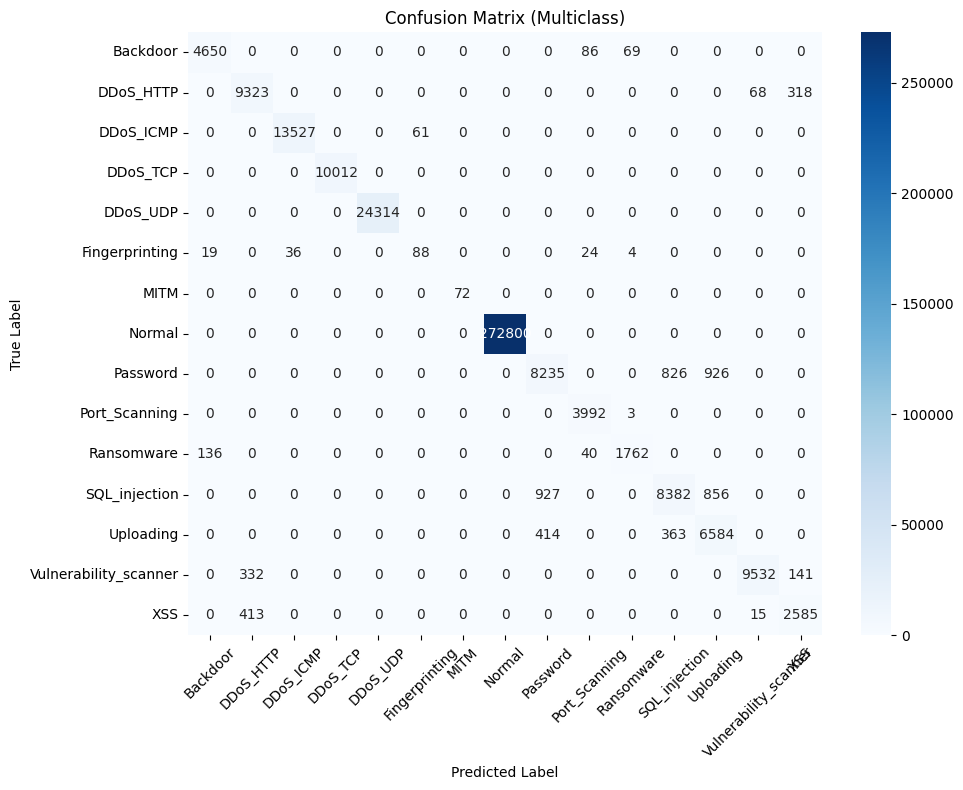


Classification Report:
                       precision    recall  f1-score   support

             Backdoor     0.9677    0.9677    0.9677      4805
            DDoS_HTTP     0.9260    0.9602    0.9428      9709
            DDoS_ICMP     0.9973    0.9955    0.9964     13588
             DDoS_TCP     1.0000    1.0000    1.0000     10012
             DDoS_UDP     1.0000    1.0000    1.0000     24314
       Fingerprinting     0.5906    0.5146    0.5500       171
                 MITM     1.0000    1.0000    1.0000        72
               Normal     1.0000    1.0000    1.0000    272800
             Password     0.8600    0.8246    0.8419      9987
        Port_Scanning     0.9638    0.9992    0.9812      3995
           Ransomware     0.9587    0.9092    0.9333      1938
        SQL_injection     0.8758    0.8246    0.8494     10165
            Uploading     0.7870    0.8944    0.8373      7361
Vulnerability_scanner     0.9914    0.9527    0.9717     10005
                  XSS     0.84

In [23]:
plot_multiclass_confusion_matrix(y_test, xgb_pred, encoder.classes_)

# Part B : poisoning 

Evaluating Original Model on Clean Data
Original - Accuracy: 0.9841

 Evaluating Model on 5% Flipped Labels
Flip 5% - Accuracy: 0.9349

 Evaluating Model on 10% Flipped Labels
Flip 10% - Accuracy: 0.8858

 Evaluating Model on 15% Flipped Labels
Flip 15% - Accuracy: 0.8366

 Evaluating Model on 20% Flipped Labels
Flip 20% - Accuracy: 0.7875


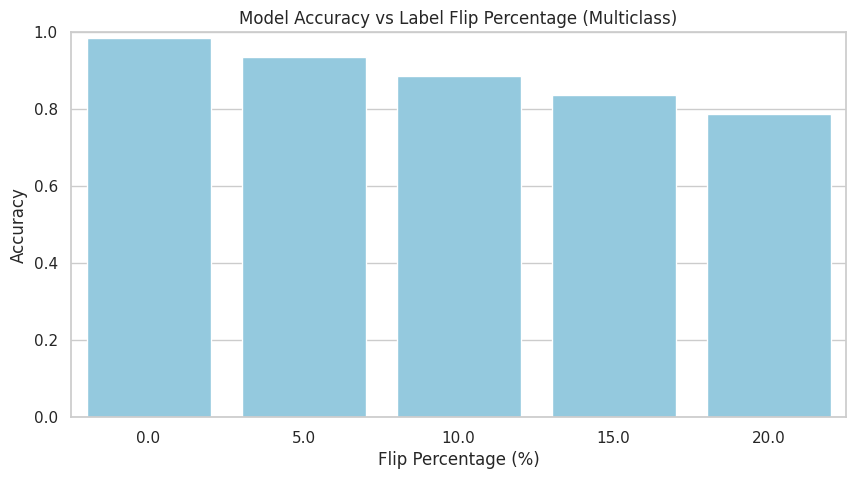

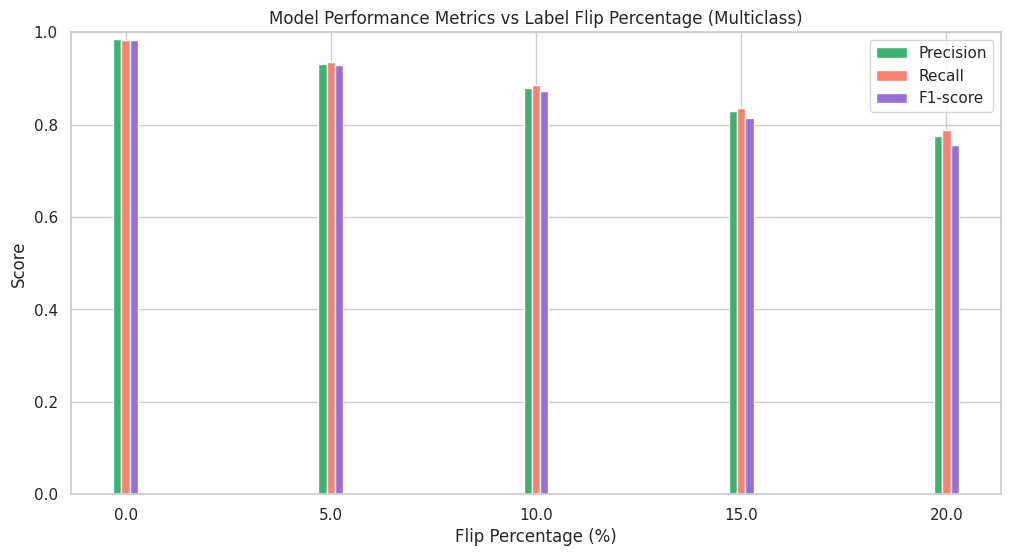

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import seaborn as sns 

def flip_multiclass_labels(y_data, flip_percentage, num_classes):
    y_data_flipped = np.array(y_data).copy()
    n_samples = len(y_data)
    n_flip = int(n_samples * flip_percentage)

    flip_indices = np.random.choice(n_samples, n_flip, replace=False)
    for idx in flip_indices:
        original_class = y_data_flipped[idx]
        possible_classes = list(set(range(num_classes)) - {original_class})
        y_data_flipped[idx] = np.random.choice(possible_classes)
    
    return y_data_flipped

# Flip settings
flip_percentages = [0.05, 0.10, 0.15, 0.20]
performance = {"flip_percentage": [], "accuracy": [], "precision": [], "recall": [], "f1-score": []}

# Original evaluation
print("Evaluating Original Model on Clean Data")
y_pred_labels = xgb_model.predict(X_test_flat)
report = classification_report(y_test, y_pred_labels, output_dict=True, zero_division=0)

performance["flip_percentage"].append(0)
performance["accuracy"].append(report["accuracy"])
performance["precision"].append(report["weighted avg"]["precision"])
performance["recall"].append(report["weighted avg"]["recall"])
performance["f1-score"].append(report["weighted avg"]["f1-score"])

print(f'Original - Accuracy: {report["accuracy"]:.4f}')

# Poisoned label evaluation
for flip_percentage in flip_percentages:
    print(f"\n Evaluating Model on {flip_percentage*100:.0f}% Flipped Labels")

    y_test_flipped = flip_multiclass_labels(y_test, flip_percentage, num_classes=len(encoder.classes_))
    y_pred_labels = xgb_model.predict(X_test_flat)

    report = classification_report(y_test_flipped, y_pred_labels, output_dict=True, zero_division=0)

    performance["flip_percentage"].append(flip_percentage * 100)
    performance["accuracy"].append(report["accuracy"])
    performance["precision"].append(report["weighted avg"]["precision"])
    performance["recall"].append(report["weighted avg"]["recall"])
    performance["f1-score"].append(report["weighted avg"]["f1-score"])

    print(f'Flip {flip_percentage*100:.0f}% - Accuracy: {report["accuracy"]:.4f}')
    
sns.set(style="whitegrid")

# Bar Plot: Accuracy at each flip percentage
plt.figure(figsize=(10, 5))
sns.barplot(x=performance["flip_percentage"], y=performance["accuracy"], color='skyblue')
plt.xlabel("Flip Percentage (%)")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs Label Flip Percentage (Multiclass)")
plt.ylim(0, 1)
plt.show()

# Bar Plot: Precision, Recall, F1-Score grouped by flip %
metrics = ["precision", "recall", "f1-score"]
colors = ['mediumseagreen', 'salmon', 'mediumpurple']

plt.figure(figsize=(12, 6))
bar_width = 0.2
flip_ticks = np.array(performance["flip_percentage"])

for i, metric in enumerate(metrics):
    plt.bar(flip_ticks + i * bar_width, performance[metric], width=bar_width, label=metric.capitalize(), color=colors[i])

plt.xlabel("Flip Percentage (%)")
plt.ylabel("Score")
plt.title("Model Performance Metrics vs Label Flip Percentage (Multiclass)")
plt.xticks(flip_ticks + bar_width, flip_ticks)
plt.ylim(0, 1)
plt.legend()
plt.show()


<!-- import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Function to flip labels
def flip_labels(y_train, flip_percentage):
    n_samples = len(y_train)
    n_flip = int(n_samples * flip_percentage)
    flip_indices = np.random.choice(n_samples, n_flip, replace=False)
    y_train_flipped = y_train.copy()
    
    for idx in flip_indices:
        current_label = np.argmax(y_train_flipped[idx])
        new_label = np.random.choice([i for i in range(y_train_flipped.shape[1]) if i != current_label])
        y_train_flipped[idx] = to_categorical(new_label, num_classes=y_train_flipped.shape[1])
    
    return y_train_flipped

# Flip percentages
flip_percentages = [0.05, 0.10, 0.15, 0.20]
performance = {"flip_percentage": [], "accuracy": [], "precision": [], "recall": [], "f1_score": []}

# Training and Evaluation
for flip_percentage in flip_percentages:
    y_train_flipped = flip_labels(y_train, flip_percentage)

    # Train model with flipped labels
    model.fit(X_train, y_train_flipped, epochs=2, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluate model
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Compute classification metrics
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
    
    performance["flip_percentage"].append(flip_percentage * 100)
    performance["accuracy"].append(report["accuracy"])
    performance["precision"].append(report["macro avg"]["precision"])
    performance["recall"].append(report["macro avg"]["recall"])
    performance["f1_score"].append(report["macro avg"]["f1-score"])

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(performance["flip_percentage"], performance["accuracy"], marker='o', label='Accuracy', color='blue')
plt.xlabel("Flip Percentage (%)")
plt.ylabel("Accuracy")
plt.title("Impact of Label Flipping on Model Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Plot Precision, Recall, F1-score
plt.figure(figsize=(10, 5))
plt.plot(performance["flip_percentage"], performance["precision"], marker='o', label='Precision', color='green')
plt.plot(performance["flip_percentage"], performance["recall"], marker='s', label='Recall', color='red')
plt.plot(performance["flip_percentage"], performance["f1_score"], marker='^', label='F1 Score', color='purple')
plt.xlabel("Flip Percentage (%)")
plt.ylabel("Score")
plt.title("Impact of Label Flipping on Model Performance Metrics")
plt.grid(True)
plt.legend()
plt.show()
 -->